# 基本信息
在训练集或者验证集中标注了目标信息，可以计算

1、目标的类别

2、目标的尺寸位置(y1,x1,y2,x2)

3、目标的面积

4、宽高比

5、目标的多边形面积

6、面积比

In [9]:
# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
import os, json
import numpy as np
import skimage.draw
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to data set
DATASET = "D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\\"

class MyConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mask"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + my

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800  
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0

    # BACKBONE = "resnet50"
    # BACKBONE_STRIDES = [4, 8, 16, 32, 64]
   # # BACKBONE_STRIDES = [2, 4, 8, 16, 32]
    # RPN_ANCHOR_SCALES = (10, 32, 64, 128, 256)
    # RPN_ANCHOR_STRIDE = 2
    # RPN_NMS_THRESHOLD = 0.9
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    # TRAIN_ROIS_PER_IMAGE = 512

############################################################
#  Dataset
############################################################

class MyDataset(utils.Dataset):

    def print_size(self, poly):
        for p in poly:
            a = np.array(p['all_points_y'])
            height = a.max() - a.min()
            a = np.array(p['all_points_x'])
            width = a.max() - a.min()
            self.areas.append(height * width)
            #if height * width < 4096:
            #    print(width, height)

    def load_my(self, dataset_dir, subset, class_dict):
        """Load a subset of the My dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.areas = []
        # Add classes. We have only one class to add.
        for (k, v) in class_dict.items():
            self.add_class("my", v, k)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            # print(a['regions'])
            # print(a['filename'])
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                if a['regions']:
                    class_ids = []
                    polygons = []
                    for r in a['regions']:
                        polygons.append(r['shape_attributes'])
                        class_type = r['region_attributes']['type']
                        class_ids.append(class_dict[class_type])
                        
                    self.print_size(polygons)
                    # print(class_ids)
                        

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
                    image_path = os.path.join(dataset_dir, a['filename'])
                    image = skimage.io.imread(image_path)
                    height, width = image.shape[:2]

                    self.add_image(
                        "my",
                        image_id=a['filename'],  # use file name as a unique image id
                        path=image_path,
                        width=width, height=height,
                        polygons=polygons,
                        class_ids=class_ids)
        self.areas.sort()
        print(np.unique(np.round(np.sqrt(self.areas))))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a my dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "my":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
        class_ids = np.array(info['class_ids'])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "my":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

target = {
    'file' : '',
    'objs' : []
}
obj = {
    'class_id' : 1,
    'bbox' : [],
    'bbox_area' : 123,
    'wh_ratio' : 0.34,
    'mask_area' : 123,
    'mask_ratio' : 0.1,
    'score' : 1
}
config = MyConfig()
class_dict = {}
label_file = open(DATASET+'label.txt')
label_lines = label_file.readlines()
label_id = 1
for label_line in label_lines:
    label_line = label_line.replace('\n', '')
    class_dict[label_line] = label_id
    label_id = label_id + 1
# Validation dataset
dataset_val = MyDataset()
dataset_val.load_my(DATASET, "val", class_dict)
dataset_val.prepare()
gt_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    print(dataset_val.image_reference(image_id))
    target['file'] = dataset_val.image_reference(image_id)
    target['objs'] = []
    for i in range(0,len(gt_class_id)):
        box_height = gt_box[i][2] - gt_box[i][0]
        box_width = gt_box[i][3] - gt_box[i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(gt_mask[:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {}
        obj['class_id'] = gt_class_id[i]
        obj['bbox'] = gt_box[i]
        obj['bbox_area'] = box_area
        obj['wh_ratio'] = box_ratio
        obj['mask_area'] = mask_area
        obj['mask_ratio'] = mask_ratio
        target['objs'].append(obj)
        print(gt_class_id[i], gt_box[i], box_area, box_ratio, mask_area, mask_ratio)
    gt_targets.append(target)
print(gt_targets)


[ 58.  59.  60.  61.  62.  63.  64.  65.  67.  68.  70.  73.  74.  75.
  76.  78.  80.  82.  83.  84.  85.  86.  87.  88.  89.  92.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 125. 127.
 128. 129. 130. 132. 134. 135. 136. 137. 138. 139. 142. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 182. 266. 267. 268. 269. 270.
 271. 272. 273. 274. 275. 276. 277. 278. 279. 280. 281. 282. 283. 284.
 285. 286. 349. 350. 351. 352. 353. 354. 355. 356. 358. 363. 365. 367.
 368. 369. 370. 371. 372. 373. 375. 376. 377. 378. 379. 380. 381. 382.
 383. 384. 387. 402. 404. 405. 406. 407. 408. 409. 410.]
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00028.jpeg
7 [ 321  803  740 1022] 91761 0.522673031026253 62338 0.679351794335284
7 [329   1 757 186] 79180 0.4322429906542056 56305 0.7111012882040919
2 [321 702 465 760] 8352 0.4027777777777778 4294 0.5141283524904214
2 [390 812 600 902] 18900 

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00035.jpeg
7 [ 316  801  738 1022] 93262 0.523696682464455 63379 0.6795801076537068
3 [305 666 667 798] 47784 0.36464088397790057 8246 0.17256822367319605
7 [327   2 762 187] 80475 0.42528735632183906 57203 0.7108170239204722
3 [238 557 498 589] 8320 0.12307692307692308 3760 0.4519230769230769
3 [232 479 512 498] 5320 0.06785714285714285 4107 0.7719924812030076
3 [241 384 491 424] 10000 0.16 3873 0.3873
3 [272 331 500 359] 6384 0.12280701754385964 2890 0.4526942355889724
3 [318 182 674 323] 50196 0.3960674157303371 6994 0.13933381145908041
2 [324 226 463 276] 6950 0.3597122302158273 3612 0.5197122302158274
2 [396  86 593 189] 20291 0.5228426395939086 8348 0.4114139273569563
2 [321 696 465 765] 9936 0.4791666666666667 4965 0.49969806763285024
2 [389 812 601 903] 19292 0.42924528301886794 8504 0.4408044785403276
4 [261   3 542 309] 85986 1.0889679715302492 12913 0.15017560998302049
4 [240 384 281 446] 2542 1.5121951219512195 1157 0

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00042.jpeg
7 [ 321  800  740 1022] 93018 0.5298329355608592 63445 0.6820722870842203
7 [327   2 761 186] 79856 0.423963133640553 56691 0.7099153476257263
2 [322 225 463 276] 7191 0.3617021276595745 3850 0.5353914615491586
2 [396  89 593 190] 19897 0.5126903553299492 8439 0.424134291601749
2 [319 700 474 762] 9610 0.4 5181 0.5391259105098856
2 [389 812 604 905] 19995 0.4325581395348837 9019 0.45106276569142284
3 [310 666 666 798] 46992 0.3707865168539326 7482 0.15921859039836567
3 [238 478 413 497] 3325 0.10857142857142857 3034 0.9124812030075188
3 [242 386 518 425] 10764 0.14130434782608695 3945 0.3664994425863991
3 [270 331 500 358] 6210 0.11739130434782609 2777 0.4471819645732689
3 [317 179 673 322] 50908 0.40168539325842695 7148 0.1404101516461067
4 [255   2 544 310] 89012 1.065743944636678 14165 0.15913584685210982
4 [240 383 281 446] 2583 1.5365853658536586 1188 0.45993031358885017
4 [237 528 274 591] 2331 1.7027027027027026

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00049.jpeg
7 [ 318  799  741 1022] 94329 0.5271867612293144 64199 0.680586033987427
7 [327   2 755 189] 80036 0.4369158878504673 57471 0.7180643710330351
2 [323 222 462 277] 7645 0.39568345323741005 4010 0.5245258338783518
2 [398  88 592 187] 19206 0.5103092783505154 8157 0.4247110278038113
2 [322 701 466 759] 8352 0.4027777777777778 4687 0.5611829501915708
2 [389 811 602 905] 20022 0.4413145539906103 9335 0.4662371391469384
3 [302 666 666 799] 48412 0.36538461538461536 7220 0.14913657770800628
3 [264 618 495 643] 5775 0.10822510822510822 3033 0.5251948051948052
3 [238 477 393 496] 2945 0.12258064516129032 2763 0.9382003395585738
3 [241 384 502 424] 10440 0.1532567049808429 3552 0.34022988505747126
3 [267 330 501 360] 7020 0.1282051282051282 3177 0.45256410256410257
3 [317 180 678 324] 51984 0.3988919667590028 7379 0.14194752231455832
4 [258   3 541 307] 86032 1.0742049469964665 13424 0.1560349637344244
4 [240 383 282 446] 2646 1

# 目标检测数据

对数据集，如验证集（val）、测试集（test）等都可以，每张图片检测后把结果收集。

检测结果：类别、ROIS、目标框面积、宽高比、掩码面积、面积比、得分

In [4]:
import time
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir="D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\\")
model.load_weights("D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\mask_rcnn_mask_0500.h5", by_name=True)
detect_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    # print(gt_box)
    start_time = time.time()
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    end_time = time.time()
    print("Time: %s" % str(end_time - start_time))
    # print(results)
    r = results[0]
    target = {
        'file' : dataset_val.image_reference(image_id),
        'objs' : []
    }
    print(dataset_val.image_reference(image_id))
    for i in range(0,len(r['class_ids'])):
        box_height = r['rois'][i][2] - r['rois'][i][0]
        box_width = r['rois'][i][3] - r['rois'][i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(r['masks'][:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {
            'class_id' : r['class_ids'][i],
            'bbox' : r['rois'][i],
            'bbox_area' : box_area,
            'wh_ratio' : box_ratio,
            'mask_area' : mask_area,
            'mask_ratio' : mask_ratio,
            'score' : r['scores'][i]
        }
        target['objs'].append(obj)
        print(r['class_ids'][i], r['rois'][i], box_area, box_ratio, mask_area, mask_ratio, r['scores'][i])
    detect_targets.append(target)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 500
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 6.003100872039795
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00028.jpeg
3 [310 673 670 806] 47880 0.36944444444444446 6720 0.14035087719298245 0.99999785
4 [ 250  674  544 1010] 98784 1.1428571428571428 12149 0.12298550372529965 0.9999875
4 [239 530 273 591] 2074 1.7941176470588236 873 0.42092574734811955 0.99998224
2 [387 802 611 901] 22176 0.4419642857142857 7608 0.3430735930735931 0.999969
3 [244 479 611 504] 9175 0.0681198910

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.49086761474609375
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00033.jpeg
4 [ 252  683  547 1022] 100005 1.1491525423728814 12587 0.12586370681465928 0.999987
3 [315 676 683 817] 51888 0.38315217391304346 4107 0.07915124884366327 0.9999763
2 [392 804 596 900] 19584 0.47058823529411764 7559 0.3859783496732026 0.99994516
4 [238 529 273 590] 2135 1.7428571428571429 801 0.37517564402810305 0.9998363
3 [238 385 528 425] 11600 0.13793103448275862 3076 0.26517241379310347 0.9997937
3 [328 185 678 311] 44100 0.36 4666 0.10580498866213152 0.9997024
2 [321 227 466 273] 6670 0.3172413

Time: 0.4928426742553711
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00038.jpeg
4 [ 252  682  546 1024] 100548 1.163265306122449 12477 0.12408998687194175 0.9999918
4 [238 530 274 596] 2376 1.8333333333333333 967 0.406986531986532 0.99998164
3 [262 334 516 359] 6350 0.0984251968503937 2436 0.3836220472440945 0.99979407
2 [394 806 601 895] 18423 0.42995169082125606 7204 0.3910329479455029 0.9997789
4 [243 388 279 451] 2268 1.75 854 0.3765432098765432 0.99963427
2 [322 227 466 273] 6624 0.3194444444444444 3251 0.49079106280193235 0.9995571
3 [324 672 673 835] 56887 0.4670487106017192 3127 0.05496862200502751 0.9993223
3 [326 185 684 311] 45108 0.35195530726256985 4329 0.09596967278531525 0.9992761
3 [238 383 525 426] 12341 0.14982578397212543 3036 0.2460092375010129 0.99857426
2 [385  83 589 180] 19788 0.47549019607843135 6774 0.34232868405093997 0.9985487
5 [255 320 359 367] 4888 0.4519230769230769 3201 0.6548690671031097 0.9966011
2 [322 700 482 767] 10720 0.41875 2444 0.2

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.5168101787567139
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00044.jpeg
4 [ 242  692  557 1021] 103635 1.0444444444444445 11926 0.11507695276692237 0.99994504
3 [261 334 512 360] 6526 0.10358565737051793 2442 0.3741955255899479 0.9996331
4 [239 530 275 591] 2196 1.6944444444444444 897 0.40846994535519127 0.9996275
3 [244 384 539 428] 12980 0.14915254237288136 2862 0.2204930662557781 0.99956113
2 [324 227 464 274] 6580 0.3357142857142857 3345 0.5083586626139818 0.9993818
2 [319 701 476 765] 10048 0.40764331210191085 3936 0.39171974522292996 0.999226
3 [324 181 671 314] 4615

3 [322 182 672 316] 46900 0.38285714285714284 5211 0.11110874200426439 0.99873704
4 [267  35 558 319] 82644 0.9759450171821306 8348 0.10101156768791443 0.9963558
2 [412  90 593 185] 17195 0.5248618784530387 6276 0.3649898226228555 0.995611
2 [317 703 464 767] 9408 0.43537414965986393 2388 0.2538265306122449 0.9931376
7 [298  11 756 220] 95722 0.45633187772925765 51486 0.537870082112785 0.96832585
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Time: 0.6147820949554443
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\val\scene00050.jpeg
4 [ 272  687  587 1024] 106155 1.0698412698412698 9211 0.08676934670999953 0.99998987
3 [267 333 508 358] 6

# 标注目标的正方形尺寸

上面已知标注的目标尺寸与宽高比，可以计算目标的正方形尺寸

$$Size = \lceil \frac {width}{ \sqrt {wh\_ratio}} \rceil$$

尺寸$Size$向上取整。

宽高比$wh\_ratio$设定为小数点后一位，进位后舍弃后面的小数。

In [17]:
import math
# print(gt_targets)
gt_wh_ratios = []
gt_sizes = []
for target in gt_targets:
    for obj in target['objs']:
        width = obj['bbox'][3] - obj['bbox'][1]
        size = width / math.sqrt(obj['wh_ratio'])
        gt_sizes.append(size)
        gt_wh_ratios.append(obj['wh_ratio'])
obj_wh_ratios = []
obj_sizes = []
for target in detect_targets:
    for obj in target['objs']:
        width = obj['bbox'][3] - obj['bbox'][1]
        size = width / math.sqrt(obj['wh_ratio'])
        obj_sizes.append(size)
        obj_wh_ratios.append(obj['wh_ratio'])


# 尺寸、宽高比分布

横坐标为尺寸，纵坐标为宽高比，把所有标注目标绘制坐标图

主要查看目标的分布情况，猜测目标有7类，又在同一场景，不会有多少点

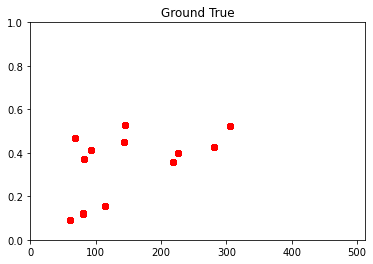

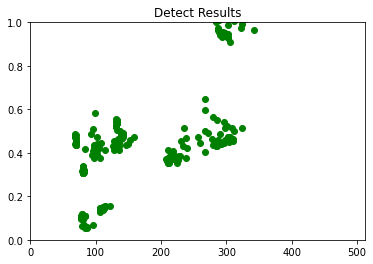

In [20]:
import matplotlib.pyplot as plt
plt.title("Ground True")
plt.plot(gt_sizes, gt_wh_ratios, 'ro')
plt.axis([0, 512, 0, 1])
plt.show()
plt.title("Detect Results")
plt.plot(obj_sizes, obj_wh_ratios, 'go')
plt.axis([0, 512, 0, 1])
plt.show()

# 覆盖测试

人工不可能把所有目标的尺寸和宽高比逐个设置。现实做法是设置几个代表性的尺寸，如32、64、128。代表性的宽高比，如0.5、1、2

代表性数据不可能把所有目标都覆盖（IOU）

根据上述坐标图的数据分布情况，设置代表性尺寸、宽高比，在每个目标上标识最大的交并比（IOU）。

最大交并比（IOU）：理想值就是目标本身，但是以理想值为代表值，必然造成其它目标的交并比（IOU）下降。

三维坐标图：尺寸、宽高比、IOU

理想状态是IOU值足够高（0~1），足以用于目标的过滤。

# 代表性的尺寸、宽高比挑选（实验性）

人工设置代表值达到IOU理想状态也不现实。。。

怎么让计算机挑选代表值？